# Classification

In [1]:
!git init; git pull https://github.com/nehal-sharma/HackDay.git

Initialized empty Git repository in /content/.git/
remote: Enumerating objects: 18, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 18 (delta 2), reused 18 (delta 2), pack-reused 0
Unpacking objects: 100% (18/18), done.
From https://github.com/nehal-sharma/HackDay
 * branch            HEAD       -> FETCH_HEAD


In [2]:
!pushd data; wget https://raw.githubusercontent.com/univai-mlcfb-c1/Homework/main/data/01_heights_weights_genders.csv; popd 

/content/data /content
--2021-01-23 04:24:31--  https://raw.githubusercontent.com/univai-mlcfb-c1/Homework/main/data/01_heights_weights_genders.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 418121 (408K) [text/plain]
Saving to: ‘01_heights_weights_genders.csv’

01_heights_weights_ 100%[===================>] 408.32K  --.-KB/s    in 0.02s   

2021-01-23 04:24:31 (18.8 MB/s) - ‘01_heights_weights_genders.csv’ saved [418121/418121]

/content


$$
\renewcommand{\like}{{\cal L}}
\renewcommand{\loglike}{{\ell}}
\renewcommand{\err}{{\cal E}}
\renewcommand{\dat}{{\cal D}}
\renewcommand{\hyp}{{\cal H}}
\renewcommand{\Ex}[2]{E_{#1}[#2]}
\renewcommand{\x}{{\mathbf x}}
\renewcommand{\v}[1]{{\mathbf #1}}
$$

In [3]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd

In [4]:
from matplotlib.colors import ListedColormap
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

def points_plot(ax, Xtr, Xte, ytr, yte, clf, mesh=True, colorscale=cmap_light, cdiscrete=cmap_bold, alpha=0.1, psize=10, zfunc=False, predicted=False):
    h = .02
    X=np.concatenate((Xtr, Xte))
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))

    #plt.figure(figsize=(10,6))
    if zfunc:
        p0 = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 0]
        p1 = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
        Z=zfunc(p0, p1)
    else:
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    ZZ = Z.reshape(xx.shape)
    if mesh:
        plt.pcolormesh(xx, yy, ZZ, cmap=cmap_light, alpha=alpha, axes=ax)
    if predicted:
        showtr = clf.predict(Xtr)
        showte = clf.predict(Xte)
    else:
        showtr = ytr
        showte = yte
    ax.scatter(Xtr[:, 0], Xtr[:, 1], c=showtr-1, cmap=cmap_bold, s=psize, alpha=alpha,edgecolor="k")
    # and testing points
    ax.scatter(Xte[:, 0], Xte[:, 1], c=showte-1, cmap=cmap_bold, alpha=alpha, marker="s", s=psize+10)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    return ax,xx,yy

In [5]:
def points_plot_prob(ax, Xtr, Xte, ytr, yte, clf, colorscale=cmap_light, cdiscrete=cmap_bold, ccolor=cm, psize=10, alpha=0.1):
    ax,xx,yy = points_plot(ax, Xtr, Xte, ytr, yte, clf, mesh=False, colorscale=colorscale, cdiscrete=cdiscrete, psize=psize, alpha=alpha, predicted=True) 
    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=ccolor, alpha=.2, axes=ax)
    cs2 = plt.contour(xx, yy, Z, cmap=ccolor, alpha=.6, axes=ax)
    plt.clabel(cs2, fmt = '%2.1f', colors = 'k', fontsize=14, axes=ax)
    return ax 

## Using `sklearn`: The heights and weights example

We'll use a dataset of heights and weights of males and females to hone our understanding of classifiers. We load the data into a dataframe and plot it.

In [6]:
df=pd.read_csv("data/01_heights_weights_genders.csv")
df.head()

,Gender,Height,Weight
0,Male,73.847017,241.893563
1,Male,68.781904,162.310473
2,Male,74.110105,212.740856
3,Male,71.730978,220.042470
4,Male,69.881796,206.349801


Remember that the form of data we will use always is

![dataform](https://github.com/nehal-sharma/HackDay/blob/main/images/dataform.jpg?raw=1)

with the "response" as a plain array

`[1,1,0,0,0,1,0,1,0....]`.

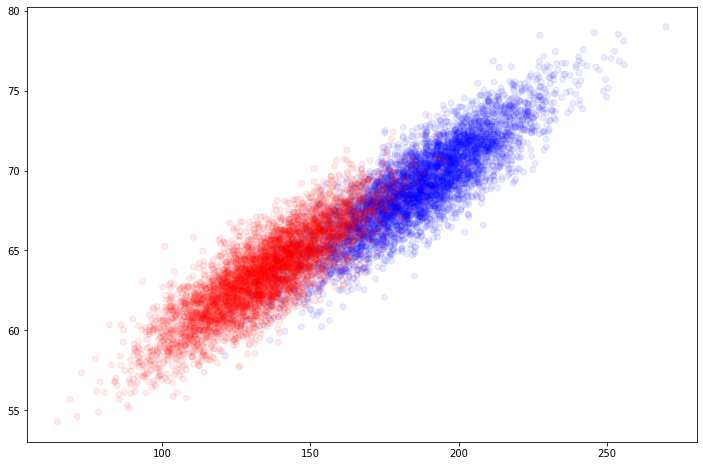

In [7]:
plt.figure(figsize=(12,8))
plt.scatter(df.Weight, df.Height, c=[cm_bright.colors[i] for i in df.Gender=="Male"], alpha=0.08);

We take a sample of 1000 data points

In [8]:
dflog=df.sample(1000, replace=False, random_state=1973)
np.sum(dflog.Gender=="Male")

503

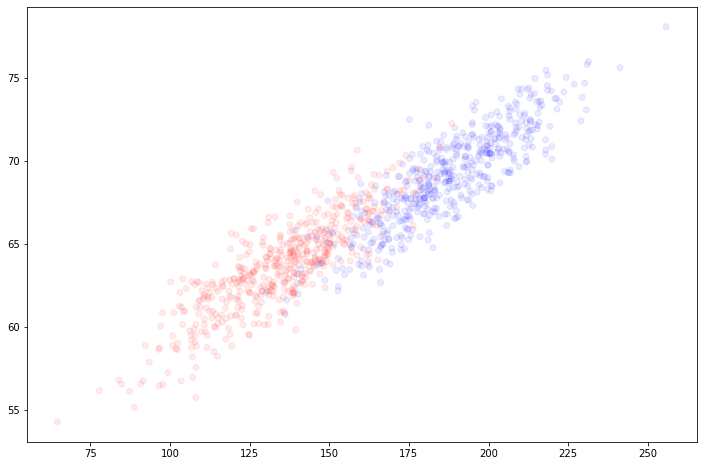

In [9]:
plt.figure(figsize=(12,8))
plt.scatter(dflog.Weight, dflog.Height, c=[cm_bright.colors[i] for i in dflog.Gender=="Male"], alpha=0.08);

And creaate a logistic regression model, like in lab

In [10]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
Xlr, Xtestlr, ylr, ytestlr = train_test_split(dflog[['Height','Weight']].values, (dflog.Gender=="Male").values)

In [11]:
Xlr.shape , Xtestlr.shape

((750, 2), (250, 2))

We run a Logistic Regression with 5 fold cross validation:

In [12]:
ylr[0:10]

array([False, False, False,  True,  True,  True,  True,  True,  True,
        True])

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
clfl=LogisticRegression()
parameters = {"C": [0.0001, 0.001, 0.1, 1, 10, 100]}
fitmodel = GridSearchCV(clfl, param_grid=parameters, cv=5, scoring="accuracy")

## Q1

>fit this model on the training set. Predict for this model and calculate its accuracy on the test set `Xtestlr`. Store the predictions in `ypred` and print the accuracy

In [ ]:
# your code here


In [ ]:
plt.figure(figsize = (12, 8))
ax=plt.gca()
points_plot(ax, Xlr, Xtestlr, ylr, ytestlr, fitmodel, alpha=0.4, predicted=True);

Here the colors are the colors of the predictions on the scatter. The background coloring tells us how any region of the "feature space" will be predicted. 

## Classifying  with kNN

![m:knn1](https://github.com/nehal-sharma/HackDay/blob/main/images/knn1.png?raw=1)

Implicit in the notion of classification, is the idea that samples close to each other in feature-space share a label. kNN is a very simple algorithm to diretly use this idea to do classification. The basic notion is this: if a lot of samples in some area of the feature space belong to one class as compared to the other, we'll label that part of the feature space as "belonging" to that class. This process will then classify the feature space into class-based regions. Then, given the point in feature space, we find which region its in and thus its class. 

The way kNN does this is to ask for the k nearest neighbors in the training set of the new sample. To answer this question, one must define a distance in the feature space (Note that this distance is different from the error or risk measures we have seen earlier). This distance is typically defined as the **Euclidean distance**, the sum of the square of the difference of each feature value between any two samples.

$$D(s_1,s_2) = \sum_f (x_{f1} - x_{f2})^2.$$

Once we have a distance measure, we can sort the distances from the current sample. Then we choose the $k$ closest ones in the training set, where $k$ is an odd number (to break ties) like 1,3,5,...19,. We now see how many of these $k$ "nearest neighbors" belong to one class or the other, and choose the majority class amongst those neighbors as our sample's class.

The training process thus simply consists of memorizing the data, perhaps using a database to aid in the fast lookup of the $k$ nearest training set neighbors of any point in feature space. Notice that this process divides feature space into regions of one class or the other, since one can simply ask what the $k$ nearest neighbors in the training set are of any given point in feature space. Also notice that since classification happens via a majority "voting" scheme, we also know the probability that a point in feature space belongs to a class, as estimated by the fraction of $k$ nearest neighbors to that point in the desired class.

Thanks to `sklearn`'s simple api, the classifier is really simple to write:

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
ys=(dflog.Gender=="Male").values

#for kNN you must standardize
subdf=dflog[['Height','Weight']]
subdfstd=(subdf - subdf.mean())/subdf.std()
Xs=subdfstd.values

Standardizing a data set involves scaling the data so that it has 0 mean and is described in units of its standard deviation.

Why do you need to standardize? Suppose you measure weight in kilos but height in meteres. Now weights have numbers in the 50-150 range where as heights are in the 1-2 metre range. The weight units will dominate the height units and the distance is skewed. Thus we need to make these quantities unitless, and divinding by the standard deviation puts them on the same scale.

But this standardization is actually not quite accurate: it leaks data from the test set into the training set. We'll talk about this on hack day. Let us just do this now.

We write a function to capture our classification process

In [ ]:
def classify(X,y, nbrs, plotit=True, train_size=0.6):
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=train_size)
    clf= KNeighborsClassifier(nbrs)
    clf=clf.fit(Xtrain, ytrain)
    #in sklearn accuracy can be found by using "score". It predicts and then gets the accuracy
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    Xall=np.concatenate((Xtrain, Xtest))
    if plotit:
        print("Accuracy on training data: %0.2f" % (training_accuracy))
        print("Accuracy on test data:     %0.2f" % (test_accuracy))
        plt.figure(figsize=(12,8))
        ax=plt.gca()
        points_plot(ax, Xtrain, Xtest, ytrain, ytest, clf, alpha=0.2, psize=20, predicted=True)
    return nbrs, training_accuracy, test_accuracy

## Q2

Lets see what happens when we choose $k=1$ . On the training set, the 1NN classifier memorizes the training data. Run this a few times and tell us your interpretation of the results and plot, and how these change from run to run. We have not chosen a random seed for the train-test split so the training sets and test sets differ from run to run..

What do you seen about the training and testing accuracy?

In [ ]:
classify(Xs,ys,1) # run this a few times

*your answer here*


### Choosing a large k

If we choose too large a number for $k$, such as 50, we are wandering too far from our original data point,and thus we average over a large amount of the feature space. This leads to a very **biased** (underfit) classification, depending on where our sample is, but extending far out from there. Our classification may even cover the entire feature space, then giving us the majority class.

Imagine $k=N$. Then the probability is just the fraction of training set examples in a given class. Say this number for the blue class is 0.4 (that is, whe have uneven class memberships in the training set). Now, on any random test set, if we use the classifier which says "classify all as red", we will be correct, on average, 60% of the time if the test set and training sets are representative of the population of samples. Any classifier we create must do a better job than this!

In [ ]:
classify(Xs,ys, 579)

In [ ]:
classify(Xs,ys, 600)

![m:knn2](https://github.com/nehal-sharma/HackDay/blob/main/images/knn2.png?raw=1)

These notions of overfitting and underfitting are illustrated in the image above: the small circles represent small $k$ neighborhoods while the large circle indicates a large $k$ neighborhood. The lower left part of that circle would likely be classified red even though it would seem to be visually more on the blue side of things.

The circle of in-between size illustrates what a reasonable $k$ might do. Also notice that kNN will be quite stable far away from the classification bondary, but is likely to be more jagged near the classification boundary. Having a reasonable number for $k$ will "smooth" the jaged edges out.

We thus once again need to find the balance between the high bias (large $k$) case and the high variance (low $k$) case, and once again we turn to our error vs complexity curve to find the appropriate $k$,

## Error against complexity (k)

Lets try different k, we'll choose them from 1 to 50, in steps of 2. For each $k$, we'll do 50 replications of the classification, on different training and test sets as the train-test split will be slightly different. This will give us an idea of the variance in our predictions, similar to the hairy plots we created for polynomial regression, except that we will see variances in both training and test accuracies. The error bars we will get underestimate the actual variance as the errors are correlated due to overlaps in training and test sets. Nevertheless its a nice illustration of variance as a function of k.

(this will take a bit of time to run, as it does 25x50 models)

In [ ]:
fits={}
nbrs = np.arange(1,50,2)
for k in nbrs:
    fits[k]=[]
    for i in range(50):#for each k, do it 50 times
        fits[k].append(classify(Xs, ys,k, False))
#nbrs=np.arange(1,500,1)
fmeanstr = np.array([1.-np.mean([t[1] for t in fits[e]]) for e in nbrs])
fmeanste = np.array([1.-np.mean([t[2] for t in fits[e]]) for e in nbrs])
fstdsstr = np.array([np.std([t[1] for t in fits[e]]) for e in nbrs])
fstdsste = np.array([np.std([t[2] for t in fits[e]]) for e in nbrs])

In [ ]:
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
c0=cycle[0]
c1=cycle[1]

We now plot "1 - accuracy" which is a sort of loss...

In [ ]:
plt.figure(figsize=(12,8))
plt.gca().invert_xaxis()
plt.plot(nbrs, fmeanstr, color=c0, label="training");
plt.fill_between(nbrs, fmeanstr - fstdsstr, fmeanstr+fstdsstr, color=c0, alpha=0.3)
plt.plot(nbrs, fmeanste, color=c1, label="testing");
plt.fill_between(nbrs, fmeanste - fstdsste, fmeanste+fstdsste, color=c1, alpha=0.5)

plt.legend();

## Q3 Interpret the results

Why does the blue line go down to 0? Why is the orange band bigger? Why have I reversed the x-axis which plots the k's ?

*your answer here*


## Q4 Find the right k using cross-validation

Just before we did an informal replication to understand the complexity curve and its uncertainty for the kNN model. Now do it the right way, using cross-validation with 5 folds on the training set. Use the same set of k's from 1-50, but this time use all k's in that range. Also note that you must keep the train-test split constant for all the k's to make a fair comparison. Doing the train test split once (you can use the 1973 random state), and letting `GridSearchCV` do the internal training set splits will suffice. Make sure to make a similar plot to cross validation plot from the ValidationRegularization repo. Just remember that there will be no uncertainty  on the training curve, but uncertainty on the validation error  due to averaging over the 5 cross-validation folds.